<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-llm-serving-and-optimization/02_llm_execution_workthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install --quiet transformers tiktoken transformers_stream_generator bertviz

In [2]:
import torch
import gc
import time

# Unload models and clean up gpu memory cache
def free_gpu(model):
  if model:
    # Removes the reference to the model's memory,
    # making it eligible for garbage collection.
    del model

  # Release any cached GPU memory that's no longer needed.
  torch.cuda.empty_cache()

  # Trigger garbage collection to ensure memory is fully released.
  gc.collect()


## Text generation

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Initialize the text generation pipeline
generator = pipeline('text-generation', model='Qwen/Qwen2.5-0.5B')

In [5]:
# Define your prompt
prompt = "Write a short introduction about US capital city."

# Generate text
generated_text = generator(prompt, max_length=50, num_return_sequences=1)

# Print the generated text
print(generated_text[0]['generated_text'])

free_gpu(generator.model)

Write a short introduction about US capital city. The United States capital city, Washington D.C., is a bustling metropolis with a long history of political and cultural significance. It was founded during the colonial era by the English and has been a center of American government, politics, and culture ever since. The city is home to the National Mall, the Lincoln Memorial, and the National Archives, among others, which are a testament to its rich history. Washington D.C. is also known for its famous monuments, such as the Washington Monument and the National Cathedral, which continue to inspire visitors and residents alike.


## Step by step generation

Let's break it up the generator function to examine step by step.

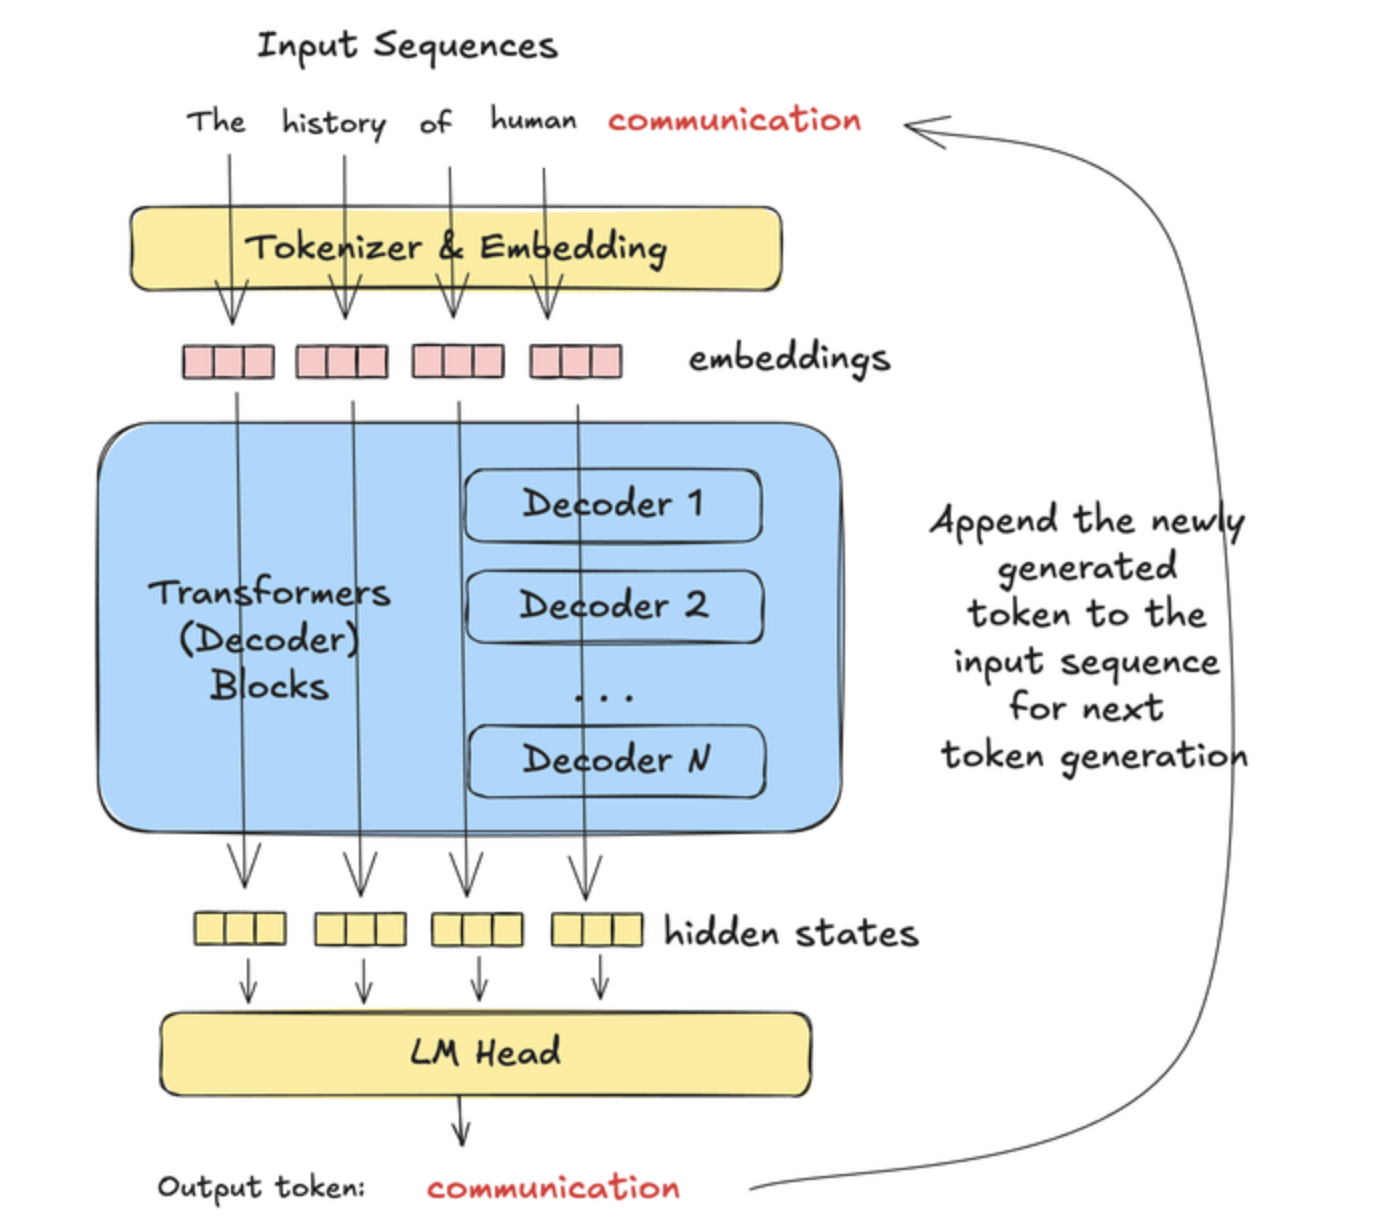

In [6]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

first_token_generated = False

# (1) Specify the model and load tokenizer and model
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# (2) Define the input prompt - a text about communication history
prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

In [8]:
# (3) Convert (Tokenize) prompt to the input format that model understands
max_new_tokens = 100
# tokenize the input prompt for the first output token
# PS: prompt is the initial input sequence for LLM generation
idx = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

In [12]:
start_time = total_time = time.time()
times = []

# (4) Main generation loop - generate tokens one by one
for _ in range(max_new_tokens):

    # (A) Set the current context for generation
    idx_cond = idx
    with torch.no_grad():
        # (B) Generate predictions (token candidates) for next token
        outputs = model(idx_cond)
        # Get the logits (raw prediction scores) for each token predictions
        logits = outputs.logits
        # print(f"logits shape: {logits.shape}")

    # (C) Select next token from the predictions generated in step (B)
    logits = logits[:, -1, :] #  Select only the logits for the last token
    probas = torch.softmax(logits, dim=-1) # Convert logits to probabilities using softmax
    # print(f"probabilities : {probas.shape}")
    # Sample the next token from the probability distribution of the predicted tokens from step (B)
    idx_next = torch.multinomial(probas, num_samples=1)
    print("Next Token is:", tokenizer.decode(idx_next[0], skip_special_tokens=True))
    time_cost = time.time() - start_time
    times.append(time_cost)

    # Track time spent in token generation
    if not first_token_generated:
        print(f"Time taken for generating the first token: {time_cost:.4f} seconds")
        first_token_generated = True
    else:
        print(f"Time taken for generating a token: {time_cost:.4f} seconds")

    start_time = time.time()

    # (D) Append the new token to the input sequence
    idx = torch.cat((idx, idx_next), dim=1)

    # (E) Check if end-of-sequence token was generated
    if idx_next.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

# Decode the entire generated sequence
generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

# Free GPU memory
free_gpu(model=model)

Next Token is: ,
Time taken for generating a token: 0.2054 seconds
Next Token is:  and
Time taken for generating a token: 0.1602 seconds
Next Token is:  work
Time taken for generating a token: 0.1376 seconds
Next Token is: .
Time taken for generating a token: 0.1404 seconds
Next Token is:  However
Time taken for generating a token: 0.1396 seconds
Next Token is: ,
Time taken for generating a token: 0.1350 seconds
Next Token is:  it
Time taken for generating a token: 0.1337 seconds
Next Token is: 's
Time taken for generating a token: 0.1373 seconds
Next Token is:  essential
Time taken for generating a token: 0.1392 seconds
Next Token is:  to
Time taken for generating a token: 0.1440 seconds
Next Token is:  consider
Time taken for generating a token: 0.1353 seconds
Next Token is:  the
Time taken for generating a token: 0.1405 seconds
Next Token is:  long
Time taken for generating a token: 0.1417 seconds
Next Token is: -term
Time taken for generating a token: 0.1413 seconds
Next Token is: 

Let's track the latency of each token during the generation process.

In [ ]:
import matplotlib.pyplot as plt

# First chart: First bar red, others blue
plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
plt.bar(range(len(times)), times, color=['red'] + ['blue'] * (len(times) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times for each token")

# # Second chart: Exclude the first element
# plt.subplot(1, 2, 2)
# plt.bar(range(len(times) - 1), times[1:])
# plt.xlabel("Token ID")
# plt.ylabel("Time Spent in Token Generation")
# plt.title("Token Generation Times (Excluded the initial prompt tokens)")

# plt.tight_layout()
# plt.show()

## KV Cache to Boost Performance

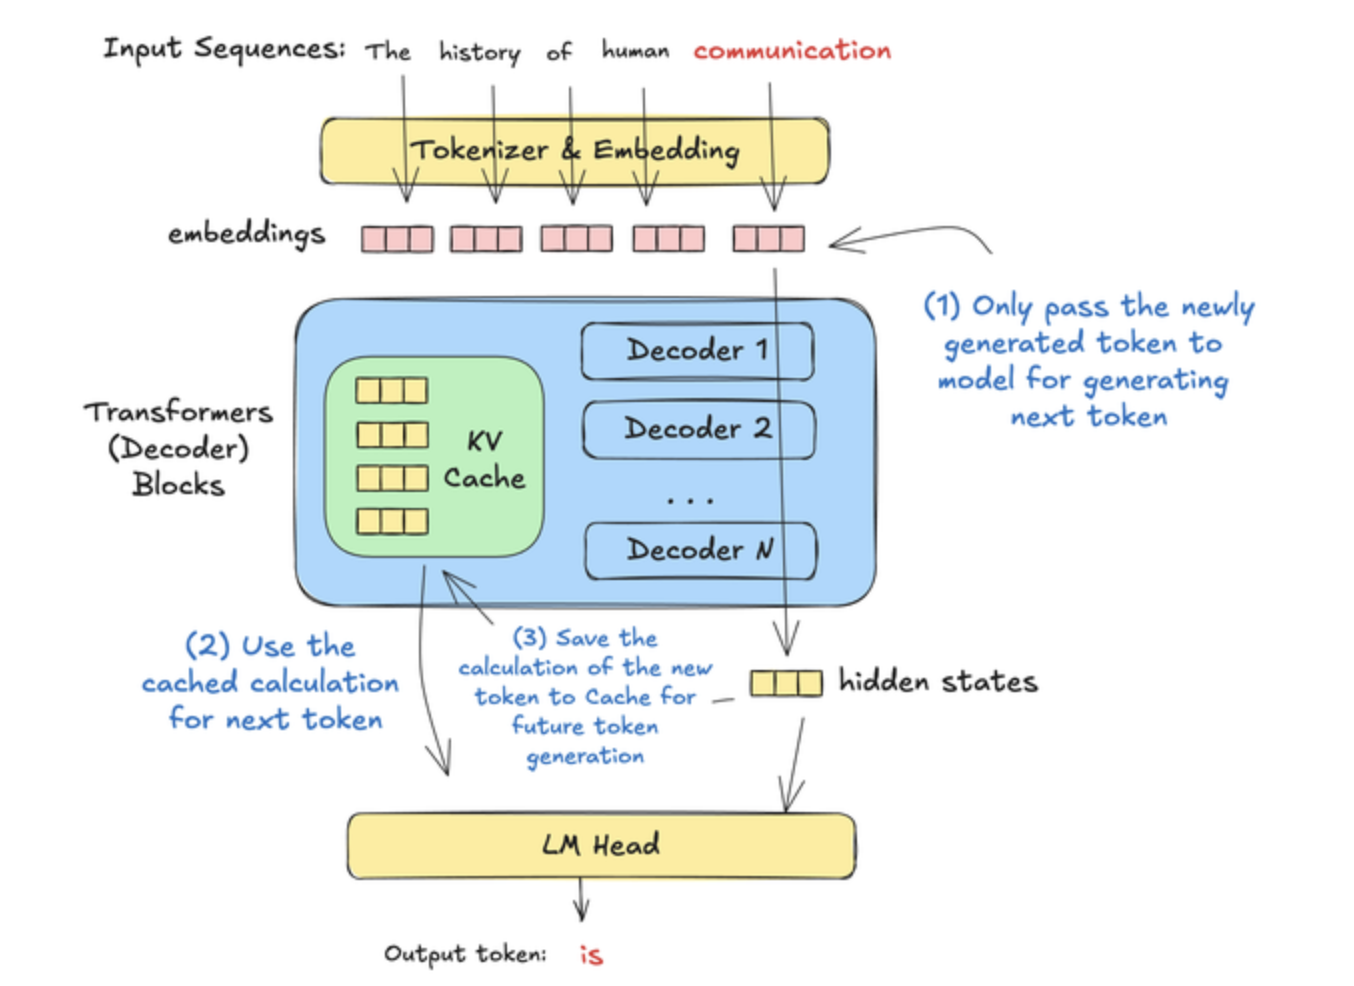

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, use_cache=True) \
            .to("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda" if torch.cuda.is_available() else "cpu")

prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

num_interations = 100
times_with_cache = []

first_token_generated = False
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
idx = input_ids
start_time = total_time = time.time()

# (1) Define Key/Value Cache for faster generation
past_key_values = None

for _ in range(num_interations):
    print("input_ids size: " + str(input_ids.size()))
    with torch.no_grad():
        outputs = model(input_ids=input_ids,
          past_key_values=past_key_values, # (2) Use KV-cache from previous iteration
          use_cache=True, # (2) Enable KV caching
          max_new_tokens = 100,
          min_new_tokens= 100)


        logits = outputs.logits
        # (3) Update KV Cache
        past_key_values = outputs.past_key_values
        torch.cuda.synchronize()

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    generated_token_id = torch.multinomial(probas, num_samples=1) # Sample instead of argmax

    # (4) Update input_ids with only the new token (using KV-cache)
    input_ids = generated_token_id  # Note: Not concatenating with previous tokens due to KV-cache

    print("Next token:", tokenizer.decode(generated_token_id[0], skip_special_tokens=True))
    idx = torch.cat((idx, generated_token_id), dim=1)

    time_cost= time.time() - start_time
    times_with_cache.append(time_cost)
    if not first_token_generated:
        print(f"Time take for first token: {time_cost:.4f} seconds")
        first_token_generated = True
    else:
        print(f"Time take for next token: {time_cost:.4f} seconds")
    start_time = time.time()

    if generated_token_id.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

free_gpu(model=model)


Show results

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Display the time cost of LLM token generation without KV Cache
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(times)), times, color=['red'] + ['blue'] * (len(times) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times (No Cache) for each token")


# Display the time cost of LLM token generation with KV Cache
plt.subplot(1, 2, 2)
plt.bar(range(len(times_with_cache)), times_with_cache, color=['red'] + ['blue'] * (len(times_with_cache) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times (with Cache) for each token")

plt.tight_layout()
plt.show()


Show Context

Show how context impact generation

In [ ]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)\
          .to("cuda" if torch.cuda.is_available() else "cpu")

prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

max_new_tokens = 50
context_size = 2048 # Define the context size as needed for Qwen

first_token_generated = False
idx = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
start_time = total_time = time.time()

for _ in range(max_new_tokens):
    # Take the latest "context_size" tokens as model input
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
        outputs = model(idx_cond)
        logits = outputs.logits

    # select next token from candidates based on probabilities.
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.multinomial(probas, num_samples=1)
    print("Decode text generated:", tokenizer.decode(idx_next[0], skip_special_tokens=True))

    idx = torch.cat((idx, idx_next), dim=1)

    if idx_next.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

# Free GPU memory
free_gpu(model=model)